In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sbermarket/Y.csv
/kaggle/input/sbermarket/X.csv
/kaggle/input/sbermarket/result.csv
/kaggle/input/test-recsys/sample_submission.csv
/kaggle/input/test-recsys/tab_6_city.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-19.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-29.csv
/kaggle/input/test-recsys/sbermarket_tab_2_4/tab_2_products_2020-06-09.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-10.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-20.csv
/kaggle/input/test-recsys/sbermarket_tab_2_3/tab_2_products_2020-05-30.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-18.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-09-07.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-08.csv
/kaggle/input/test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-28.csv
/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv


# Tema's trick

In [2]:
from glob import glob

In [3]:
%%time
import sys
!cp ../input/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

CPU times: user 1.04 s, sys: 183 ms, total: 1.22 s
Wall time: 1min 7s


In [4]:
all_files = glob('/kaggle/input/test-recsys/sbermarket_tab_*_*/*')
all_files.sort()

In [5]:
import cudf

In [6]:
%%time
dfs = []
for path in all_files[:6]:
    dfs.append(
        # reduce_mem_usage(
            cudf.read_csv(path)
        # )
    )

CPU times: user 1.32 s, sys: 742 ms, total: 2.06 s
Wall time: 2.5 s


# Some foreplay 

## Orders

In [7]:
import pandas as pd

In [8]:
orders = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')

In [9]:
orders.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
0,72,17431000,2020-09-26 10:48:57,METRO,21,app
1,83,9718154,2020-05-08 09:46:18,METRO,87,web
2,142,10056850,2020-05-14 15:06:03,METRO,320,app
3,187,15952443,2020-09-01 17:34:00,ВкусВилл,533,app
4,224,10409918,2020-05-20 06:32:50,Ашан,183,web


## Products

The collection of sales entries on some pre-selected days

In [10]:
products_2months = cudf.concat(dfs, axis=0)
products_2months.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
0,525,5354800,28381452,116.000000,4,0.00,Лазанья Золотой Петушок мясной слоеный пирог з...,37548,Золотой Петушок,101.0,99
1,525,5354800,29242911,56.990002,2,13.08,Хлеб Хлебный Дом Геркулес зерновой с отрубями ...,5636,Хлебный Дом,596.0,51
2,525,5354800,29242919,64.989998,2,40.02,Тортилья Delicados оригинальная пшеничная,22107,Delicados,596.0,51
3,525,5354800,29243785,44.990002,6,0.00,Вода питьевая минеральная BonAqua газированная...,2530,BonAqua,77.0,74
4,525,5354800,29244246,65.900002,6,30.99,"Газированный напиток Mirinda Апельсин 1,5 л",3818486,Mirinda,76.0,74


In [11]:
products_2months['spending'] = products_2months['price'] * products_2months['quantity']

### Checking that the price is given per sample (just in case)

In [12]:
df = products_2months.sort_values(by=['product_name'])
print(df.loc[(df['quantity'] == 1) 
       & (df['product_name'] == 'Bio Баланс Антиголод кисломолочный напиток с Тыквой и Бананом 1,3% 200г')].head(2))
print('___')
print(df.loc[(df['quantity'] == 3) 
       & (df['product_name'] == 'Bio Баланс Антиголод кисломолочный напиток с Тыквой и Бананом 1,3% 200г')].head(2))

        user_id  order_id  line_item_id      price  quantity  discount  \
248856   523427   5255706      28746808  35.709999         1       0.0   
277093   641395   5561402      29531785  42.189999         1       0.0   

                                             product_name  product_id  \
248856  Bio Баланс Антиголод кисломолочный напиток с Т...     5074402   
277093  Bio Баланс Антиголод кисломолочный напиток с Т...     5074402   

       brand_name  master_category_id  parent_category_id   spending  
248856       None                22.0                  20  35.709999  
277093       None                22.0                  20  42.189999  
___
        user_id  order_id  line_item_id      price  quantity  discount  \
155940   272406   5996998      33096924  35.709999         3       0.0   
415172   774488   5987975      33866065  35.709999         3       0.0   

                                             product_name  product_id  \
155940  Bio Баланс Антиголод кисломолочный н

### Checking that category (in categs) == master_category

In [13]:
products_2months.loc[products_2months['parent_category_id'] == 20].drop_duplicates(subset=['master_category_id']).master_category_id

53        21.0
113       22.0
39        23.0
69        24.0
529       25.0
15        26.0
739       27.0
51        28.0
40        29.0
77        30.0
18        31.0
17        32.0
251       33.0
45        34.0
16       607.0
778      608.0
14880    609.0
Name: master_category_id, dtype: float64

## Categories

In [14]:
categs = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv')

In [15]:
categs.head(n=10)

,id,name,parent_id
0,1,Продукты питания,0
1,2,Замороженные продукты,1
2,3,Замороженные овощи и фрукты,2
3,4,Замороженные полуфабрикаты,2
4,5,Рыба замороженная,2
5,6,Мясо замороженное,2
6,7,Мороженое,2
7,8,Пельмени и вареники,2
8,9,Бакалея,1
9,10,"Хлопья, мюсли, сухие завтраки",9


### Checking that category (in categs) == master_category

In [16]:
# categs.sort_values(by=['parent_id']).head(30)
categs.loc[categs['parent_id'] == 20].id

20      21
21      22
22      23
23      24
24      25
25      26
26      27
27      28
28      29
29      30
30      31
31      32
32      33
33      34
606    607
607    608
608    609
Name: id, dtype: int64

## Users

In [17]:
users = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')

In [18]:
users.head()

,user_id,gender,bdate
0,2224890,NaN,NaN
1,1683001,male,1987-10-11
2,2102480,NaN,NaN
3,2224895,NaN,NaN
4,930197,NaN,NaN


In [19]:
users.count()

user_id    438867
gender     207130
bdate      206987
dtype: int64

## Products properties

In [20]:
prod_props = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv')

In [21]:
prod_props.head(n=10)

,product_id,property_name,property_value
0,1,Вес,100 г
1,2,Вид,Молочный напиток
2,2,Вес,100 г
3,2,Вкус,Черника
4,2,Сырье,Натуральное молоко
5,2,Вид упаковки,Пластиковая бутылка
6,3,Вес,200 г
7,4,Вес,200 г
8,5,Вид,Молочный напиток
9,5,Вес,100 г


## Cities

In [22]:
cities = pd.read_csv('/kaggle/input/test-recsys/tab_6_city.csv')

In [23]:
cities.head()

,store_id,city_name
0,14,Москва
1,21,Москва
2,1,Москва
3,4,Москва
4,7,Москва


# The real thing happening

## The most profitable category

In [24]:
profit = products_2months.groupby('master_category_id').sum()
profit.reset_index(inplace=True)
profit = profit.astype({"master_category_id": int,})
categs = categs.rename(columns={"id": "master_category_id",})
profit = profit.to_pandas().merge(categs, 'left', 'master_category_id')
profit = profit.sort_values('spending', ascending=False)

In [244]:
prtble = profit.head(n=10)

In [281]:
top100 = profit.head(n=100)

In [285]:
np.array(top100['spending']).sum()

518864016.08681786

In [286]:
top100['spending'] = top100['spending'] / np.array(top100['spending']).sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


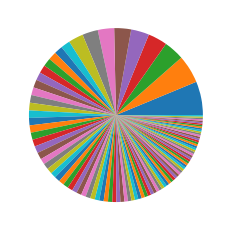

In [292]:
plt.pie(list(top100['spending']))
plt.show()

## Engineering the target for consumer basket (Y)

In [26]:
n = 100
profit_top_n = profit.head(n)

user_spendings_on_category = products_2months.groupby(['user_id','master_category_id']).sum().reset_index()
user_spendings = products_2months.groupby('user_id').sum().reset_index()[['user_id','spending']]

user_spendings = user_spendings.rename(columns={"spending": "spending_total_per_user",})
user_spendings_on_category = user_spendings_on_category.to_pandas().merge(user_spendings.to_pandas(), 'left', 'user_id')
user_spendings_on_category['spending_share'] = user_spendings_on_category['spending'] / user_spendings_on_category['spending_total_per_user']

print(user_spendings_on_category.size)

16478400


In [27]:
user_spendings_on_category.head(5)

,user_id,master_category_id,order_id,line_item_id,price,quantity,discount,product_id,parent_category_id,spending,spending_total_per_user,spending_share
0,51,16.0,11973831,68693144,143.740005,2,0.000000,113800,18,143.740005,91522.619741,0.001571
1,51,21.0,105295709,598325616,980.100002,51,75.900001,34544486,360,2788.490009,91522.619741,0.030468
2,51,24.0,59645966,340813592,470.499992,23,43.599999,15118765,200,1075.069988,91522.619741,0.011746
3,51,25.0,17933493,103900415,127.559998,10,0.000000,4410781,60,426.459991,91522.619741,0.004660
4,51,28.0,15972045,88468666,93.770002,13,7.680000,10469276,60,333.670010,91522.619741,0.003646


### Getting rid of the goods not from top_n

In [59]:
list_of_top_categories

[85,
 122,
 91,
 77,
 36,
 26,
 128,
 120,
 638,
 76,
 127,
 15,
 34,
 31,
 630,
 60,
 625,
 580,
 581,
 61,
 118,
 152,
 600,
 30,
 116,
 222,
 593,
 33,
 261,
 347,
 132,
 49,
 246,
 95,
 592,
 582,
 21,
 247,
 596,
 141,
 27,
 43,
 115,
 38,
 114,
 123,
 142,
 29,
 28,
 574,
 45,
 23,
 37,
 643,
 110,
 601,
 223,
 125,
 624,
 39,
 610,
 179,
 280,
 257,
 577,
 591,
 44,
 62,
 249,
 96,
 205,
 217,
 124,
 40,
 24,
 209,
 145,
 25,
 224,
 353,
 626,
 578,
 101,
 192,
 234,
 343,
 113,
 597,
 248,
 22,
 285,
 105,
 348,
 262,
 121,
 589,
 140,
 590,
 195,
 636]

In [58]:
list_of_top_categories = list(profit_top_n.master_category_id)
print(len(list(profit_top_n.master_category_id)))

user_spendings_on_category['spending_share'] = user_spendings_on_category['spending'] / user_spendings_on_category['spending_total_per_user']

user_spendings_on_category_2 = \
user_spendings_on_category.drop \
(user_spendings_on_category[~ user_spendings_on_category.master_category_id.isin(list_of_top_categories)]\
 .index)

print(user_spendings_on_category_2.size)
print(user_spendings_on_category_2.size / user_spendings_on_category.size)

100
13209216
0.80160792309933


### Getting rid of users with < M entries 

In [117]:
M = 20
user_bought_items = products_2months.groupby('user_id').sum().reset_index()[['user_id','quantity']]
print(len(user_bought_items)) # the total number of users

### UNCOMMENT IF RUN FOR THE 1ST TIME (to_pandas)
user_bought_items = user_bought_items.to_pandas()
user_bought_enough_items = user_bought_items.drop (user_bought_items[user_bought_items.quantity < M].index)

print(len(user_bought_enough_items))
print(len(user_bought_enough_items)/len(user_bought_items))

valid_users = list(user_bought_enough_items.user_id)

user_spendings_on_category_3 = \
user_spendings_on_category_2.drop \
(user_spendings_on_category_2[~ user_spendings_on_category_2.user_id.isin(valid_users)]\
 .index)

print(user_spendings_on_category_3.size)

64012
53535
0.8363275635818284
12497652


In [118]:
# the target is 'spending_share' for a 'user' and a 'category'
user_spendings_on_category_3.head()

,user_id,master_category_id,order_id,line_item_id,price,quantity,discount,product_id,parent_category_id,spending,spending_total_per_user,spending_share
1,51,21.0,105295709,598325616,980.100002,51,75.900001,34544486,360,2788.490009,91522.619741,0.030468
2,51,24.0,59645966,340813592,470.499992,23,43.599999,15118765,200,1075.069988,91522.619741,0.011746
3,51,25.0,17933493,103900415,127.559998,10,0.000000,4410781,60,426.459991,91522.619741,0.004660
4,51,28.0,15972045,88468666,93.770002,13,7.680000,10469276,60,333.670010,91522.619741,0.003646
5,51,30.0,17297846,98170964,202.720001,6,0.000000,2924861,60,405.440002,91522.619741,0.004430


In [119]:
user_spendings_on_category_3.size

12497652

### The Finishing Touch

In [120]:
user_spendings_on_category_f = user_spendings_on_category_3[['user_id', 'master_category_id', 'spending_share']]

In [121]:
user_spendings_on_category_f

,user_id,master_category_id,spending_share
1,51,21.0,0.030468
2,51,24.0,0.011746
3,51,25.0,0.004660
4,51,28.0,0.003646
5,51,30.0,0.004430
...,...,...,...
1373185,1028522,26.0,0.148703
1373186,1028522,31.0,0.106505
1373187,1028522,580.0,0.353961
1373188,1028522,581.0,0.220294


In [122]:
Y = pd.get_dummies(user_spendings_on_category_f.master_category_id, prefix='category')

In [123]:
Y = user_spendings_on_category_f.join(Y)

In [124]:
Y

,user_id,master_category_id,spending_share,category_15.0,category_21.0,category_22.0,category_23.0,category_24.0,category_25.0,category_26.0,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
1,51,21.0,0.030468,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51,24.0,0.011746,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51,25.0,0.004660,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,51,28.0,0.003646,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,51,30.0,0.004430,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373185,1028522,26.0,0.148703,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1373186,1028522,31.0,0.106505,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1373187,1028522,580.0,0.353961,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1373188,1028522,581.0,0.220294,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
cats_names = list(Y.columns) [3:]

In [126]:
for name in cats_names:
    Y[name] = Y[name] * Y['spending_share']

In [127]:
Y.groupby('user_id').sum().head() #note the spending_share values!

,master_category_id,spending_share,category_15.0,category_21.0,category_22.0,category_23.0,category_24.0,category_25.0,category_26.0,category_27.0,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
user_id,,,,,,,,,,,,,,,,,,,,,
51,7383.0,0.846656,0.000000,0.030468,0.0,0.0,0.011746,0.00466,0.000000,0.000000,...,0.007881,0.0,0.001442,0.000000,0.000000,0.00000,0.0,0.000879,0.003941,0.0
65,4986.0,0.838841,0.000000,0.006207,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00729,0.0,0.000000,0.000000,0.0
223,1625.0,0.891767,0.000000,0.193441,0.0,0.0,0.000000,0.00000,0.020876,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0
353,7699.0,0.900191,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.012879,...,0.000000,0.0,0.000000,0.008415,0.014841,0.00000,0.0,0.000000,0.067303,0.0
359,2127.0,0.870375,0.036992,0.043091,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.005409,0.0


In [128]:
Y = Y.groupby('user_id').sum().drop(columns=['master_category_id', 'spending_share']).reset_index()

In [129]:
Y.head()

,user_id,category_15.0,category_21.0,category_22.0,category_23.0,category_24.0,category_25.0,category_26.0,category_27.0,category_28.0,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
0,51,0.000000,0.030468,0.0,0.0,0.011746,0.00466,0.000000,0.000000,0.003646,...,0.007881,0.0,0.001442,0.000000,0.000000,0.00000,0.0,0.000879,0.003941,0.0
1,65,0.000000,0.006207,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00729,0.0,0.000000,0.000000,0.0
2,223,0.000000,0.193441,0.0,0.0,0.000000,0.00000,0.020876,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0
3,353,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.012879,0.054338,...,0.000000,0.0,0.000000,0.008415,0.014841,0.00000,0.0,0.000000,0.067303,0.0
4,359,0.036992,0.043091,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.038932,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.005409,0.0


## Getting features for consumer bucket prediction (X)

In [130]:
def get_order_stats(df, orders, users):
    tmp = cudf.merge(df, orders, how = 'left', on = 'order_id')
    tmp = tmp.drop(['order_created_time', 'retailer',
                    'store_id', 'platform', 'user_id_y',
                    'line_item_id', 'discount', 'product_name',
                    'product_id', 'brand_name', 'master_category_id',
                    'parent_category_id'],
                   axis = 1)
    tmp.columns = ['user_id'] + list(tmp.columns[1:])
    tmp['order_sum'] = tmp['price']*tmp['quantity']
    tmp = tmp.drop(['price', 'quantity'], axis = 1)
    tmp = tmp.groupby(['user_id', 'order_id']).sum()
    tmp = tmp.reset_index()
    tmp = tmp.drop('order_id', axis = 1)
    tmp = tmp.groupby('user_id').agg(['mean','std', 'median'])
    tmp.columns = [a+'_'+b for a,b in tmp.columns]
    tmp = tmp.reset_index()
    tmp = cudf.merge(tmp, users, how = 'left', on = 'user_id')
    return tmp

def get_discount_stats(df, users):
    tmp = df.drop(['order_id','line_item_id',
                   'price','quantity','product_name',
                   'product_id','brand_name',
                   'master_category_id','parent_category_id'],
                 axis = 1)
    tmp = tmp.groupby('user_id').agg(['mean','std', 'median'])
    tmp.columns = [a+'_'+b for a,b in tmp.columns]
    tmp = tmp.reset_index()
    tmp = cudf.merge(users, tmp, how = 'left', on = 'user_id')
    return tmp

def get_retailer_stats(df, orders, users):
    tmp = orders.copy()
    tmp = cudf.get_dummies(tmp, columns = ['retailer'])
    tmp = tmp.drop(['order_id', 'order_created_time', 'store_id', 'platform'], axis = 1)
    tmp = tmp.groupby('user_id').mean()
    tmp.reset_index(inplace = True)
    tmp = cudf.merge(users, tmp, how = 'inner', on = 'user_id')
    return tmp

def get_client_features(df, categories, orders, users, prod_props):
    result = users.copy()
    result = get_order_stats(df, orders, users)
    result = get_discount_stats(df, result)
    result = get_retailer_stats(df, orders, result)
    return result

In [131]:
# products_2months_unchanged
# categs
# users
# prod_props
# orders

In [132]:
products_2months_unchanged = cudf.concat(dfs, axis=0)
prod_props = cudf.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv')
users = cudf.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')
categs = cudf.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv')
orders = cudf.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')

In [133]:
client_features = get_client_features(products_2months_unchanged, categs, orders, users, prod_props)

In [134]:
client_features = client_features.drop(columns=['gender', 'bdate'])

In [135]:
client_features = client_features.fillna(0)

In [136]:
client_features

,user_id,order_sum_mean,order_sum_std,order_sum_median,discount_mean,discount_std,discount_median,retailer_220 ВОЛЬТ,retailer_BILLA,retailer_Gipfel,...,retailer_ТД ХОРОШИЙ,retailer_ТИТАН,"retailer_ТЦ ""Новомариинский""",retailer_ТЦ STOЛИЦА,retailer_УДАЧНАЯ ПОКУПКА,retailer_Улыбка Радуги,retailer_Фреш25,retailer_Хороший,retailer_Шан,retailer_ЮгОпт
0,57668,6422.645008,2607.138065,6422.645008,31.291077,68.108542,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57677,5673.580036,0.000000,5673.580036,98.486842,191.850470,23.600000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57992,5084.381448,3041.768380,4905.100023,73.223157,126.230772,39.995001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58112,3918.477996,1734.401633,3352.780001,19.677960,62.517851,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58013,5368.125734,2189.299225,4605.830004,22.618205,98.156345,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56469,1018250,3671.179995,0.000000,3671.179995,25.978049,40.782622,10.900000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56470,1018276,1157.259995,0.000000,1157.259995,4.000000,0.866025,4.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56471,1018319,4234.049976,0.000000,4234.049976,30.981064,57.473360,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56472,1018296,2807.290012,0.000000,2807.290012,21.052500,54.388613,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
X = client_features.to_pandas().drop(client_features[~ client_features.user_id.isin(valid_users)].index)

In [138]:
X

,user_id,order_sum_mean,order_sum_std,order_sum_median,discount_mean,discount_std,discount_median,retailer_220 ВОЛЬТ,retailer_BILLA,retailer_Gipfel,...,retailer_ТД ХОРОШИЙ,retailer_ТИТАН,"retailer_ТЦ ""Новомариинский""",retailer_ТЦ STOЛИЦА,retailer_УДАЧНАЯ ПОКУПКА,retailer_Улыбка Радуги,retailer_Фреш25,retailer_Хороший,retailer_Шан,retailer_ЮгОпт
0,57668,6422.645008,2607.138065,6422.645008,31.291077,68.108542,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57677,5673.580036,0.000000,5673.580036,98.486842,191.850470,23.600000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57992,5084.381448,3041.768380,4905.100023,73.223157,126.230772,39.995001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58112,3918.477996,1734.401633,3352.780001,19.677960,62.517851,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58013,5368.125734,2189.299225,4605.830004,22.618205,98.156345,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56468,1018307,3039.669996,0.000000,3039.669996,27.080000,88.444101,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56469,1018250,3671.179995,0.000000,3671.179995,25.978049,40.782622,10.900000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56470,1018276,1157.259995,0.000000,1157.259995,4.000000,0.866025,4.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56471,1018319,4234.049976,0.000000,4234.049976,30.981064,57.473360,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
Y

,user_id,category_15.0,category_21.0,category_22.0,category_23.0,category_24.0,category_25.0,category_26.0,category_27.0,category_28.0,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
0,51,0.000000,0.030468,0.000000,0.00000,0.011746,0.004660,0.000000,0.000000,0.003646,...,0.007881,0.0,0.001442,0.000000,0.000000,0.000000,0.0,0.000879,0.003941,0.00000
1,65,0.000000,0.006207,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.007290,0.0,0.000000,0.000000,0.00000
2,223,0.000000,0.193441,0.000000,0.00000,0.000000,0.000000,0.020876,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000
3,353,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.012879,0.054338,...,0.000000,0.0,0.000000,0.008415,0.014841,0.000000,0.0,0.000000,0.067303,0.00000
4,359,0.036992,0.043091,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.038932,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.005409,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53445,1028476,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000
53446,1028489,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.059682,0.039895,0.0,0.000000,0.000000,0.02728
53447,1028502,0.000000,0.065962,0.000000,0.00000,0.145185,0.093719,0.000000,0.000000,0.000000,...,0.036687,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.161245,0.00000
53448,1028511,0.000000,0.053047,0.022346,0.01454,0.000000,0.000000,0.059356,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.124223,0.000000,0.0,0.000000,0.000000,0.00000


In [140]:
data = X.merge(Y, 'inner', 'user_id')

In [141]:
feature_names = list(X.columns) [1:]
#cats_names

In [142]:
X_final = data[feature_names]
Y_final = data[cats_names]

In [143]:
data

,user_id,order_sum_mean,order_sum_std,order_sum_median,discount_mean,discount_std,discount_median,retailer_220 ВОЛЬТ,retailer_BILLA,retailer_Gipfel,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
0,57668,6422.645008,2607.138065,6422.645008,31.291077,68.108542,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025667,0.000000
1,57677,5673.580036,0.000000,5673.580036,98.486842,191.850470,23.600000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,57992,5084.381448,3041.768380,4905.100023,73.223157,126.230772,39.995001,0.0,0.0,0.0,...,0.014282,0.000000,0.000000,0.000000,0.010985,0.014384,0.137134,0.000000,0.000000,0.016774
3,58112,3918.477996,1734.401633,3352.780001,19.677960,62.517851,0.000000,0.0,0.0,0.0,...,0.015692,0.000000,0.000000,0.000000,0.007220,0.000000,0.000000,0.000000,0.046252,0.000000
4,58013,5368.125734,2189.299225,4605.830004,22.618205,98.156345,0.000000,0.0,0.0,0.0,...,0.000000,0.008598,0.000000,0.000000,0.010266,0.028874,0.000000,0.001461,0.044652,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47384,1018307,3039.669996,0.000000,3039.669996,27.080000,88.444101,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.143420,0.000000,0.000000,0.000000,0.082861,0.000000
47385,1018250,3671.179995,0.000000,3671.179995,25.978049,40.782622,10.900000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.021761,0.000000,0.000000,0.000000,0.000000,0.048802,0.000000
47386,1018276,1157.259995,0.000000,1157.259995,4.000000,0.866025,4.500000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
47387,1018319,4234.049976,0.000000,4234.049976,30.981064,57.473360,0.000000,0.0,0.0,0.0,...,0.011783,0.000000,0.021533,0.000000,0.000000,0.000000,0.012964,0.000000,0.000000,0.000000


## Some stuff

In [ ]:
# import gc

# del products_2months
# del orders
# del categs
# del users
# del prod_props

# gc.collect()

In [ ]:
# saving 
# Y_final.to_csv('Y.csv',index=False)

In [ ]:
# X_final.to_csv('X.csv',index=False)

## Mutual Info Regression (not enough memory) & preprocessing & loading

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [6]:
#loading
X = pd.read_csv('../input/sbermarket/X.csv')
Y = pd.read_csv('../input/sbermarket/Y.csv')
result = pd.read_csv('../input/sbermarket/result.csv')

In [7]:
from sklearn import preprocessing

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(x)
# X = pd.DataFrame(x_scaled)

x = Y.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(x)
# Y = pd.DataFrame(x_scaled)

In [175]:
# y = np.array(Y_final[cats_names[0]])
cats_names_n = list(Y.columns)[1:]
y = Y[cats_names[0]]
# mutual_info_regression(X, y, n_neighbors=2)

In [176]:
a = mutual_info_regression(X_np, y)

NameError: name 'mutual_info_regression' is not defined

In [177]:
cats_names_n

['category_15.0',
 'category_21.0',
 'category_22.0',
 'category_23.0',
 'category_24.0',
 'category_25.0',
 'category_26.0',
 'category_27.0',
 'category_28.0',
 'category_29.0',
 'category_30.0',
 'category_31.0',
 'category_33.0',
 'category_34.0',
 'category_36.0',
 'category_37.0',
 'category_38.0',
 'category_39.0',
 'category_40.0',
 'category_43.0',
 'category_44.0',
 'category_45.0',
 'category_49.0',
 'category_60.0',
 'category_61.0',
 'category_62.0',
 'category_76.0',
 'category_77.0',
 'category_85.0',
 'category_91.0',
 'category_95.0',
 'category_96.0',
 'category_101.0',
 'category_105.0',
 'category_110.0',
 'category_113.0',
 'category_114.0',
 'category_115.0',
 'category_116.0',
 'category_118.0',
 'category_120.0',
 'category_121.0',
 'category_122.0',
 'category_123.0',
 'category_124.0',
 'category_125.0',
 'category_127.0',
 'category_128.0',
 'category_132.0',
 'category_140.0',
 'category_141.0',
 'category_142.0',
 'category_145.0',
 'category_152.0',
 'cate

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X, y)

In [ ]:
random_forest.feature_importances_.reshape(-1, 1).shape

In [ ]:
result = np.zeros((67, 100))

In [ ]:
from tqdm import tqdm
for i in tqdm(range(100)):
    
    y = Y[:,i]
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest.fit(X, y)
    result[:,i] = random_forest.feature_importances_

## Deciphering the result :)

In [178]:
X = pd.read_csv('../input/sbermarket/X.csv')
Y = pd.read_csv('../input/sbermarket/Y.csv')
cats_names = list(Y.columns)

In [179]:
cats_ids = [float(el[9:]) for el in cats_names]

In [180]:
cats_ids

[15.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 33.0,
 34.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 43.0,
 44.0,
 45.0,
 49.0,
 60.0,
 61.0,
 62.0,
 76.0,
 77.0,
 85.0,
 91.0,
 95.0,
 96.0,
 101.0,
 105.0,
 110.0,
 113.0,
 114.0,
 115.0,
 116.0,
 118.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 127.0,
 128.0,
 132.0,
 140.0,
 141.0,
 142.0,
 145.0,
 152.0,
 179.0,
 192.0,
 195.0,
 205.0,
 209.0,
 217.0,
 222.0,
 223.0,
 224.0,
 234.0,
 246.0,
 247.0,
 248.0,
 249.0,
 257.0,
 261.0,
 262.0,
 280.0,
 285.0,
 343.0,
 347.0,
 348.0,
 353.0,
 574.0,
 577.0,
 578.0,
 580.0,
 581.0,
 582.0,
 589.0,
 590.0,
 591.0,
 592.0,
 593.0,
 596.0,
 597.0,
 600.0,
 601.0,
 610.0,
 624.0,
 625.0,
 626.0,
 630.0,
 636.0,
 638.0,
 643.0]

In [61]:
list_of_top_categories.sort()

In [62]:
list_of_top_categories

[15,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 43,
 44,
 45,
 49,
 60,
 61,
 62,
 76,
 77,
 85,
 91,
 95,
 96,
 101,
 105,
 110,
 113,
 114,
 115,
 116,
 118,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 128,
 132,
 140,
 141,
 142,
 145,
 152,
 179,
 192,
 195,
 205,
 209,
 217,
 222,
 223,
 224,
 234,
 246,
 247,
 248,
 249,
 257,
 261,
 262,
 280,
 285,
 343,
 347,
 348,
 353,
 574,
 577,
 578,
 580,
 581,
 582,
 589,
 590,
 591,
 592,
 593,
 596,
 597,
 600,
 601,
 610,
 624,
 625,
 626,
 630,
 636,
 638,
 643]

In [209]:
categs = categs.to_pandas()

In [210]:
categs.head(21)

,name,parent_id
id,,
1,Продукты питания,0
2,Замороженные продукты,1
3,Замороженные овощи и фрукты,2
4,Замороженные полуфабрикаты,2
5,Рыба замороженная,2
6,Мясо замороженное,2
7,Мороженое,2
8,Пельмени и вареники,2
9,Бакалея,1


In [211]:
type(categs)

pandas.core.frame.DataFrame

In [212]:
categs.loc[5]['name']

'Рыба замороженная'

In [226]:
cats_names = [categs.loc[float(el[9:])]['name'] for el in cats_names_n]

In [219]:
# cats_names.sort()
# cats_names

['Бритвы',
 'Бумажные платки и салфетки',
 'Бумажные полотенца',
 'Вода питьевая и минеральная',
 'Все для выпечки и десертов',
 'Газированные напитки',
 'Гели для душа',
 'Губки, тряпки',
 'Дезодоранты',
 'Детские молочные продукты ',
 'Еда быстрого приготовления',
 'Женские прокладки и тампоны',
 'Жидкие средства для стирки',
 'Заменители молока и смеси',
 'Замороженные овощи и смеси',
 'Замороженные полуфабрикаты',
 'Замороженные фрукты и ягоды',
 'Зелень, салаты, смеси',
 'Зубные пасты',
 'Икра',
 'Йогурты',
 'Капсулы и таблетки для стирки',
 'Каши',
 'Кисломолочные продукты',
 'Колбасы варено-копченые и полукопченые',
 'Колбасы вареные',
 'Колбасы сырокопченые и сыровяленые',
 'Кондиционеры и ополаскиватели для белья',
 'Консервы из рыбы и морепродуктов',
 'Конфеты и сладкие подарочные наборы',
 'Корм для кошек',
 'Корм для собак',
 'Кофе',
 'Крупы',
 'Макаронные изделия и паста',
 'Мармелад, зефир, пастила',
 'Мешки для мусора',
 'Молоко',
 'Молочные коктейли и напитки',
 'Морепр

In [215]:
cats_ids

[15.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 33.0,
 34.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 43.0,
 44.0,
 45.0,
 49.0,
 60.0,
 61.0,
 62.0,
 76.0,
 77.0,
 85.0,
 91.0,
 95.0,
 96.0,
 101.0,
 105.0,
 110.0,
 113.0,
 114.0,
 115.0,
 116.0,
 118.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 127.0,
 128.0,
 132.0,
 140.0,
 141.0,
 142.0,
 145.0,
 152.0,
 179.0,
 192.0,
 195.0,
 205.0,
 209.0,
 217.0,
 222.0,
 223.0,
 224.0,
 234.0,
 246.0,
 247.0,
 248.0,
 249.0,
 257.0,
 261.0,
 262.0,
 280.0,
 285.0,
 343.0,
 347.0,
 348.0,
 353.0,
 574.0,
 577.0,
 578.0,
 580.0,
 581.0,
 582.0,
 589.0,
 590.0,
 591.0,
 592.0,
 593.0,
 596.0,
 597.0,
 600.0,
 601.0,
 610.0,
 624.0,
 625.0,
 626.0,
 630.0,
 636.0,
 638.0,
 643.0]

In [224]:
test = list(prtble['name'])

In [225]:
test.sort()
test

['Бритвы',
 'Бумажные платки и салфетки',
 'Бумажные полотенца',
 'Вода питьевая и минеральная',
 'Все для выпечки и десертов',
 'Газированные напитки',
 'Гели для душа',
 'Губки, тряпки',
 'Дезодоранты',
 'Детские молочные продукты ',
 'Еда быстрого приготовления',
 'Женские прокладки и тампоны',
 'Жидкие средства для стирки',
 'Заменители молока и смеси',
 'Замороженные овощи и смеси',
 'Замороженные полуфабрикаты',
 'Замороженные фрукты и ягоды',
 'Зелень, салаты, смеси',
 'Зубные пасты',
 'Икра',
 'Йогурты',
 'Капсулы и таблетки для стирки',
 'Каши',
 'Кисломолочные продукты',
 'Колбасы варено-копченые и полукопченые',
 'Колбасы вареные',
 'Колбасы сырокопченые и сыровяленые',
 'Кондиционеры и ополаскиватели для белья',
 'Консервы из рыбы и морепродуктов',
 'Конфеты и сладкие подарочные наборы',
 'Корм для кошек',
 'Корм для собак',
 'Кофе',
 'Крупы',
 'Макаронные изделия и паста',
 'Мармелад, зефир, пастила',
 'Мешки для мусора',
 'Молоко',
 'Молочные коктейли и напитки',
 'Морепр

In [185]:
features = list(X.columns)

In [186]:
renaming_rows = {}
for i in range(67):
    renaming_rows[i] = features[i]

In [90]:
result = pd.read_csv('../input/sbermarket/results_f.csv')
result = result.rename(index = renaming_rows)
result.columns = cats_names

In [91]:
result

,Растительные масла,Йогурты,Питьевые йогурты,Молочные коктейли и напитки,Творожки и десерты,"Сырки, бисквиты",Молоко,Сливки,Кисломолочные продукты,Сметана,...,"Печенье, пряники, вафли",Торты и пирожные,Чипсы,Консервы из рыбы и морепродуктов,Овощные консервы и соленья,"Оливки, маслины, каперсы","Соки, нектары и морсы","Зелень, салаты, смеси",Замороженные овощи и смеси,"Пельмени, манты, вареники"
order_sum_mean,0.131608,1.448444e-01,0.160779,1.683036e-01,1.578419e-01,0.169709,1.836948e-01,0.164896,1.569002e-01,1.592169e-01,...,1.552038e-01,1.655924e-01,1.553685e-01,0.154989,1.565568e-01,1.520553e-01,1.577763e-01,0.159187,1.441353e-01,1.439203e-01
order_sum_std,0.067357,7.587120e-02,0.073626,1.085686e-01,6.816483e-02,0.063999,7.594173e-02,0.089841,7.158976e-02,7.229604e-02,...,7.171826e-02,9.113617e-02,5.509997e-02,0.074469,7.025924e-02,6.114708e-02,7.321432e-02,0.074197,6.765702e-02,6.756353e-02
order_sum_median,0.128155,1.422337e-01,0.145152,1.810224e-01,1.414074e-01,0.168411,1.599235e-01,0.154162,1.486189e-01,1.547211e-01,...,1.506470e-01,1.657269e-01,1.643122e-01,0.152606,1.502128e-01,1.394740e-01,1.485966e-01,0.156647,1.455050e-01,1.518241e-01
discount_mean,0.223136,2.196713e-01,0.214766,2.121230e-01,2.272210e-01,0.246282,1.928164e-01,0.208580,2.352813e-01,2.296176e-01,...,2.130512e-01,2.160491e-01,1.667878e-01,0.236378,2.217176e-01,2.424976e-01,2.016709e-01,0.246828,2.329145e-01,2.111076e-01
discount_std,0.246039,2.157968e-01,0.208519,1.926404e-01,2.238990e-01,0.200277,1.822633e-01,0.211073,2.036564e-01,2.164401e-01,...,2.189061e-01,2.129697e-01,2.370123e-01,0.212906,2.200385e-01,2.237402e-01,2.036240e-01,0.234234,2.364784e-01,2.174190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
retailer_Улыбка Радуги,0.000064,2.505464e-08,0.000000,0.000000e+00,1.619386e-08,0.000000,1.531792e-05,0.000000,4.258235e-07,5.321868e-06,...,9.819996e-07,1.577338e-07,6.493021e-07,0.000000,8.006466e-09,4.530688e-08,1.905652e-07,0.000012,1.382906e-07,0.000000e+00
retailer_Фреш25,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Хороший,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Шан,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [250]:
'Свежие овощи' in cats_names

True

## Feature Similarity

In [198]:
result

,Растительные масла,Йогурты,Питьевые йогурты,Молочные коктейли и напитки,Творожки и десерты,"Сырки, бисквиты",Молоко,Сливки,Кисломолочные продукты,Сметана,...,"Печенье, пряники, вафли",Торты и пирожные,Чипсы,Консервы из рыбы и морепродуктов,Овощные консервы и соленья,"Оливки, маслины, каперсы","Соки, нектары и морсы","Зелень, салаты, смеси",Замороженные овощи и смеси,"Пельмени, манты, вареники"
order_sum_mean,0.131608,1.448444e-01,0.160779,1.683036e-01,1.578419e-01,0.169709,1.836948e-01,0.164896,1.569002e-01,1.592169e-01,...,1.552038e-01,1.655924e-01,1.553685e-01,0.154989,1.565568e-01,1.520553e-01,1.577763e-01,0.159187,1.441353e-01,1.439203e-01
order_sum_std,0.067357,7.587120e-02,0.073626,1.085686e-01,6.816483e-02,0.063999,7.594173e-02,0.089841,7.158976e-02,7.229604e-02,...,7.171826e-02,9.113617e-02,5.509997e-02,0.074469,7.025924e-02,6.114708e-02,7.321432e-02,0.074197,6.765702e-02,6.756353e-02
order_sum_median,0.128155,1.422337e-01,0.145152,1.810224e-01,1.414074e-01,0.168411,1.599235e-01,0.154162,1.486189e-01,1.547211e-01,...,1.506470e-01,1.657269e-01,1.643122e-01,0.152606,1.502128e-01,1.394740e-01,1.485966e-01,0.156647,1.455050e-01,1.518241e-01
discount_mean,0.223136,2.196713e-01,0.214766,2.121230e-01,2.272210e-01,0.246282,1.928164e-01,0.208580,2.352813e-01,2.296176e-01,...,2.130512e-01,2.160491e-01,1.667878e-01,0.236378,2.217176e-01,2.424976e-01,2.016709e-01,0.246828,2.329145e-01,2.111076e-01
discount_std,0.246039,2.157968e-01,0.208519,1.926404e-01,2.238990e-01,0.200277,1.822633e-01,0.211073,2.036564e-01,2.164401e-01,...,2.189061e-01,2.129697e-01,2.370123e-01,0.212906,2.200385e-01,2.237402e-01,2.036240e-01,0.234234,2.364784e-01,2.174190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
retailer_Улыбка Радуги,0.000064,2.505464e-08,0.000000,0.000000e+00,1.619386e-08,0.000000,1.531792e-05,0.000000,4.258235e-07,5.321868e-06,...,9.819996e-07,1.577338e-07,6.493021e-07,0.000000,8.006466e-09,4.530688e-08,1.905652e-07,0.000012,1.382906e-07,0.000000e+00
retailer_Фреш25,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Хороший,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Шан,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [105]:
#result.to_csv('result_correct.csv',index=False)

# Analysis of what has just happened

## Insight 1: Sugar consumption

In [228]:
cats_names

['Растительные масла',
 'Йогурты',
 'Питьевые йогурты',
 'Молочные коктейли и напитки',
 'Творожки и десерты',
 'Сырки, бисквиты',
 'Молоко',
 'Сливки',
 'Кисломолочные продукты',
 'Сметана',
 'Творог',
 'Сливочное масло и маргарин',
 'Мороженое',
 'Яйца',
 'Твердые и полутвердые сыры',
 'Мягкие и полумягкие сыры',
 'Рассольные сыры',
 'Творожные сыры',
 'Плавленые сыры',
 'Колбасы вареные',
 'Колбасы варено-копченые и полукопченые',
 'Колбасы сырокопченые и сыровяленые',
 'Мясные деликатесы',
 'Шоколад и шоколадные батончики',
 'Конфеты и сладкие подарочные наборы',
 'Мармелад, зефир, пастила',
 'Газированные напитки',
 'Вода питьевая и минеральная',
 'Свежие овощи',
 'Свежие фрукты ',
 'Орехи',
 'Сухофрукты',
 'Еда быстрого приготовления',
 'Пельмени и вареники',
 'Замороженные полуфабрикаты',
 'Икра',
 'Рыбные деликатесы',
 'Рыба охлажденная',
 'Рыба замороженная',
 'Морепродукты',
 'Мясо охлажденное',
 'Мясо замороженное',
 'Мясо птицы',
 'Полуфабрикаты из мяса',
 'Полуфабрикаты из

In [229]:
cats_ids

[15.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 33.0,
 34.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 43.0,
 44.0,
 45.0,
 49.0,
 60.0,
 61.0,
 62.0,
 76.0,
 77.0,
 85.0,
 91.0,
 95.0,
 96.0,
 101.0,
 105.0,
 110.0,
 113.0,
 114.0,
 115.0,
 116.0,
 118.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 127.0,
 128.0,
 132.0,
 140.0,
 141.0,
 142.0,
 145.0,
 152.0,
 179.0,
 192.0,
 195.0,
 205.0,
 209.0,
 217.0,
 222.0,
 223.0,
 224.0,
 234.0,
 246.0,
 247.0,
 248.0,
 249.0,
 257.0,
 261.0,
 262.0,
 280.0,
 285.0,
 343.0,
 347.0,
 348.0,
 353.0,
 574.0,
 577.0,
 578.0,
 580.0,
 581.0,
 582.0,
 589.0,
 590.0,
 591.0,
 592.0,
 593.0,
 596.0,
 597.0,
 600.0,
 601.0,
 610.0,
 624.0,
 625.0,
 626.0,
 630.0,
 636.0,
 638.0,
 643.0]

In [230]:
order_sum_mean = list(result.iloc[0]) 

In [231]:
import matplotlib.pyplot as plt

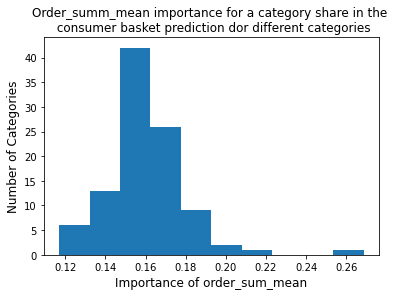

In [263]:
plt.hist(order_sum_mean)
plt.xlabel('Importance of order_sum_mean', size=12)
plt.ylabel('Number of Categories', size=12)
plt.title('Order_summ_mean importance for a category share in the \n consumer basket prediction dor different categories')
plt.show()

In [251]:
np.array(order_sum_mean).argmax()

77

In [234]:
cats_names[np.array(vals).argmax()]

'Сахар и сахарозаменители'

In [144]:
data

,user_id,order_sum_mean,order_sum_std,order_sum_median,discount_mean,discount_std,discount_median,retailer_220 ВОЛЬТ,retailer_BILLA,retailer_Gipfel,...,category_600.0,category_601.0,category_610.0,category_624.0,category_625.0,category_626.0,category_630.0,category_636.0,category_638.0,category_643.0
0,57668,6422.645008,2607.138065,6422.645008,31.291077,68.108542,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025667,0.000000
1,57677,5673.580036,0.000000,5673.580036,98.486842,191.850470,23.600000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,57992,5084.381448,3041.768380,4905.100023,73.223157,126.230772,39.995001,0.0,0.0,0.0,...,0.014282,0.000000,0.000000,0.000000,0.010985,0.014384,0.137134,0.000000,0.000000,0.016774
3,58112,3918.477996,1734.401633,3352.780001,19.677960,62.517851,0.000000,0.0,0.0,0.0,...,0.015692,0.000000,0.000000,0.000000,0.007220,0.000000,0.000000,0.000000,0.046252,0.000000
4,58013,5368.125734,2189.299225,4605.830004,22.618205,98.156345,0.000000,0.0,0.0,0.0,...,0.000000,0.008598,0.000000,0.000000,0.010266,0.028874,0.000000,0.001461,0.044652,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47384,1018307,3039.669996,0.000000,3039.669996,27.080000,88.444101,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.143420,0.000000,0.000000,0.000000,0.082861,0.000000
47385,1018250,3671.179995,0.000000,3671.179995,25.978049,40.782622,10.900000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.021761,0.000000,0.000000,0.000000,0.000000,0.048802,0.000000
47386,1018276,1157.259995,0.000000,1157.259995,4.000000,0.866025,4.500000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
47387,1018319,4234.049976,0.000000,4234.049976,30.981064,57.473360,0.000000,0.0,0.0,0.0,...,0.011783,0.000000,0.021533,0.000000,0.000000,0.000000,0.012964,0.000000,0.000000,0.000000


In [236]:
cats_names[77]

'Сахар и сахарозаменители'

In [239]:
share_sugar = data[cats_names_n[77]]
average_check = data['order_sum_mean']

In [240]:
from scipy.stats import pearsonr

In [241]:
pearsonr(share_sugar, average_check)

(-0.030815545669899365, 1.950823913315616e-11)

In [242]:
average_check.max()

236659.76872825625

## Insight 2

In [270]:
discount_means = list(result.loc['discount_mean'])

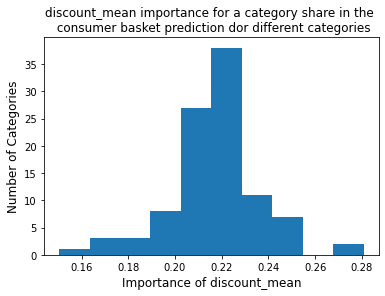

In [274]:
plt.hist(discount_means)
plt.xlabel('Importance of discount_mean', size=12)
plt.ylabel('Number of Categories', size=12)
plt.title('discount_mean importance for a category share in the \n consumer basket prediction dor different categories')
plt.show()

In [272]:
np.array(discount_means).argmax()

74

In [273]:
cats_names[74]

'Корм для кошек'

## Insight 4

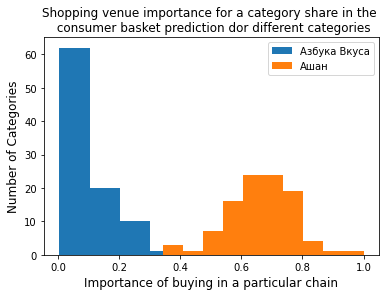

In [316]:
azbuka = list(result.loc['retailer_Азбука Вкуса'])
auchan = list(result.loc['retailer_Ашан'])

plt.hist(azbuka/np.array(azbuka).max(), label='Азбука Вкуса')
plt.hist(auchan/np.array(auchan).max(), label='Ашан')
plt.xlabel('Importance of buying in a particular chain', size=12)
plt.ylabel('Number of Categories', size=12)
plt.title('Shopping venue importance for a category share in the \n consumer basket prediction dor different categories')
plt.legend()
plt.show()

In [302]:
np.array(auchan).argmax()

27

In [303]:
cats_names[27]

'Вода питьевая и минеральная'

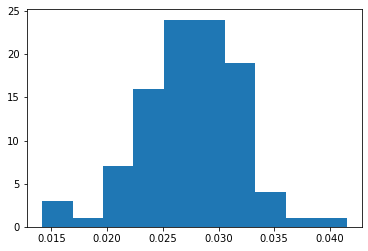

In [299]:
auchan = list(result.loc['retailer_Ашан'])
plt.hist(auchan)
#plt.xlabel('Importance of discount_mean', size=12)
#plt.ylabel('Number of Categories', size=12)
#plt.title('discount_mean importance for a category share in the \n consumer basket prediction dor different categories')
plt.show()

In [293]:
cats_names

['Растительные масла',
 'Йогурты',
 'Питьевые йогурты',
 'Молочные коктейли и напитки',
 'Творожки и десерты',
 'Сырки, бисквиты',
 'Молоко',
 'Сливки',
 'Кисломолочные продукты',
 'Сметана',
 'Творог',
 'Сливочное масло и маргарин',
 'Мороженое',
 'Яйца',
 'Твердые и полутвердые сыры',
 'Мягкие и полумягкие сыры',
 'Рассольные сыры',
 'Творожные сыры',
 'Плавленые сыры',
 'Колбасы вареные',
 'Колбасы варено-копченые и полукопченые',
 'Колбасы сырокопченые и сыровяленые',
 'Мясные деликатесы',
 'Шоколад и шоколадные батончики',
 'Конфеты и сладкие подарочные наборы',
 'Мармелад, зефир, пастила',
 'Газированные напитки',
 'Вода питьевая и минеральная',
 'Свежие овощи',
 'Свежие фрукты ',
 'Орехи',
 'Сухофрукты',
 'Еда быстрого приготовления',
 'Пельмени и вареники',
 'Замороженные полуфабрикаты',
 'Икра',
 'Рыбные деликатесы',
 'Рыба охлажденная',
 'Рыба замороженная',
 'Морепродукты',
 'Мясо охлажденное',
 'Мясо замороженное',
 'Мясо птицы',
 'Полуфабрикаты из мяса',
 'Полуфабрикаты из

In [294]:
features

['order_sum_mean',
 'order_sum_std',
 'order_sum_median',
 'discount_mean',
 'discount_std',
 'discount_median',
 'retailer_220 ВОЛЬТ',
 'retailer_BILLA',
 'retailer_Gipfel',
 'retailer_Home Market',
 'retailer_METRO',
 'retailer_REAL',
 'retailer_SELGROS',
 'retailer_YVES ROCHER',
 'retailer_fissman',
 'retailer_АГРОКОМПЛЕКС',
 'retailer_АУТЛЕТ',
 'retailer_Азбука Вкуса',
 'retailer_Аллея',
 'retailer_Ашан',
 'retailer_БАРС',
 'retailer_БЕГЕМАГ',
 'retailer_Бахетле',
 'retailer_Бетховен ',
 'retailer_Быстроном',
 'retailer_ВЕГА',
 'retailer_ВИКТОРИЯ',
 'retailer_ВкусВилл',
 'retailer_ДЕЯ',
 'retailer_Дочки-Сыночки',
 'retailer_ЗЕЛЕНОЕ ЯБЛОКО',
 'retailer_Забайкальский Привозъ',
 'retailer_ИДЕЯ',
 'retailer_Империал',
 'retailer_КАРАВАН',
 'retailer_КИТ',
 'retailer_Кировский ',
 'retailer_Командор',
 'retailer_Лента',
 'retailer_МАГНОЛИЯ',
 'retailer_МЕГАМАРТ',
 'retailer_МЯСНИЦКИЙ РЯД',
 'retailer_МаксМаркет',
 'retailer_Мегас',
 'retailer_Мираторг',
 'retailer_ОКЕЙ',
 'retailer_Опто

## Insight 5

In [318]:
result

,Растительные масла,Йогурты,Питьевые йогурты,Молочные коктейли и напитки,Творожки и десерты,"Сырки, бисквиты",Молоко,Сливки,Кисломолочные продукты,Сметана,...,"Печенье, пряники, вафли",Торты и пирожные,Чипсы,Консервы из рыбы и морепродуктов,Овощные консервы и соленья,"Оливки, маслины, каперсы","Соки, нектары и морсы","Зелень, салаты, смеси",Замороженные овощи и смеси,"Пельмени, манты, вареники"
order_sum_mean,0.131608,1.448444e-01,0.160779,1.683036e-01,1.578419e-01,0.169709,1.836948e-01,0.164896,1.569002e-01,1.592169e-01,...,1.552038e-01,1.655924e-01,1.553685e-01,0.154989,1.565568e-01,1.520553e-01,1.577763e-01,0.159187,1.441353e-01,1.439203e-01
order_sum_std,0.067357,7.587120e-02,0.073626,1.085686e-01,6.816483e-02,0.063999,7.594173e-02,0.089841,7.158976e-02,7.229604e-02,...,7.171826e-02,9.113617e-02,5.509997e-02,0.074469,7.025924e-02,6.114708e-02,7.321432e-02,0.074197,6.765702e-02,6.756353e-02
order_sum_median,0.128155,1.422337e-01,0.145152,1.810224e-01,1.414074e-01,0.168411,1.599235e-01,0.154162,1.486189e-01,1.547211e-01,...,1.506470e-01,1.657269e-01,1.643122e-01,0.152606,1.502128e-01,1.394740e-01,1.485966e-01,0.156647,1.455050e-01,1.518241e-01
discount_mean,0.223136,2.196713e-01,0.214766,2.121230e-01,2.272210e-01,0.246282,1.928164e-01,0.208580,2.352813e-01,2.296176e-01,...,2.130512e-01,2.160491e-01,1.667878e-01,0.236378,2.217176e-01,2.424976e-01,2.016709e-01,0.246828,2.329145e-01,2.111076e-01
discount_std,0.246039,2.157968e-01,0.208519,1.926404e-01,2.238990e-01,0.200277,1.822633e-01,0.211073,2.036564e-01,2.164401e-01,...,2.189061e-01,2.129697e-01,2.370123e-01,0.212906,2.200385e-01,2.237402e-01,2.036240e-01,0.234234,2.364784e-01,2.174190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
retailer_Улыбка Радуги,0.000064,2.505464e-08,0.000000,0.000000e+00,1.619386e-08,0.000000,1.531792e-05,0.000000,4.258235e-07,5.321868e-06,...,9.819996e-07,1.577338e-07,6.493021e-07,0.000000,8.006466e-09,4.530688e-08,1.905652e-07,0.000012,1.382906e-07,0.000000e+00
retailer_Фреш25,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Хороший,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
retailer_Шан,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [320]:
plt.hist(list(result['Молоко']))

[0.18369477929506767,
 0.07594173004112292,
 0.1599234665413255,
 0.19281643280671049,
 0.1822632956739871,
 0.10158814211445084,
 0.0,
 0.0009909619764333182,
 0.0,
 1.625799628114768e-07,
 0.033583776319382926,
 0.00019933417239538853,
 0.000907139157100134,
 0.0007430653670180259,
 0.0,
 1.0694027190597852e-06,
 0.0,
 0.00030872791297392336,
 0.0002452215108130473,
 0.03258110527940658,
 0.0,
 0.0,
 0.004829999415627072,
 1.5876817946788186e-06,
 8.020049718011129e-06,
 0.0,
 0.00018533736817244117,
 0.002918030912123388,
 0.0,
 2.2901437456527463e-08,
 0.0,
 0.0,
 8.308157140031898e-08,
 0.0,
 0.0,
 2.548419492303812e-05,
 0.0,
 0.0005496205071420867,
 0.0239492049041852,
 0.0004133954250477811,
 0.001283504064869114,
 0.0,
 0.0,
 8.952485622085711e-08,
 0.0,
 5.525600698420104e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.78588045736689e-07,
 0.0,
 0.0,
 2.531214861064899e-05,
 1.5317915805702973e-05,
 0.0,
 0.0,
 0.0,
 6.755645016588843e-07]